## MOSFET Power Analysis

J0 = 3.067187697019032e-13 A/cm^2
I0 = 3.0671876970190323e-09 A
I_photo = 400.0 A


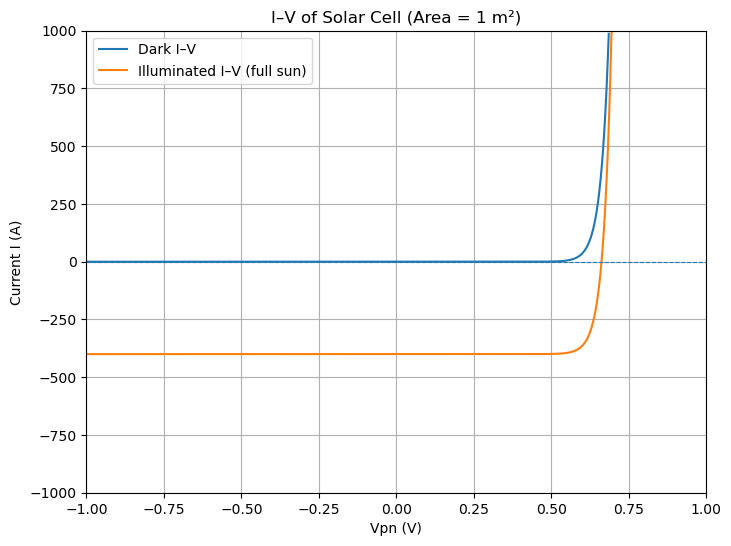

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Physical constants
q = 1.602176634e-19   # C
k_B = 1.380649e-23    # J/K
T = 300.0             # K

# Given device parameters
ni = 1.1e10           # cm^-3
Nd = 1e20             # cm^-3
Na = 1e17             # cm^-3
tau_n = 1e-5          # s
tau_p = 1e-5          # s
Dn = 25.0             # cm^2/s
Dp = 10.0             # cm^2/s

# Area
area_m2 = 1.0
area_cm2 = area_m2 * 1e4   # m^2 → cm^2

# Diffusion lengths
L_n = np.sqrt(Dn * tau_n)
L_p = np.sqrt(Dp * tau_p)

# Reverse saturation current density J0 (A/cm^2)
J0 = q * (ni**2) * (Dn/(L_n*Na) + Dp/(L_p*Nd))

# Full diode saturation current
I0 = J0 * area_cm2

# Photocurrent (40 mA/cm^2)
J_photo = 0.04       # A/cm^2
I_photo = J_photo * area_cm2

print("J0 =", J0, "A/cm^2")
print("I0 =", I0, "A")
print("I_photo =", I_photo, "A")

# Voltage sweep
V = np.linspace(-1, 1, 2001)

# Diode equation
thermal = q/(k_B*T)
with np.errstate(over='ignore'):
    I_dark = I0 * np.expm1(thermal * V)

# Under illumination
I_light = I_dark - I_photo

# y-range requirement: plot nothing outside ±1000 A
ymin, ymax = -1000, 1000
I_dark_plot  = np.where((I_dark  >= ymin) & (I_dark  <= ymax), I_dark,  np.nan)
I_light_plot = np.where((I_light >= ymin) & (I_light <= ymax), I_light, np.nan)

# Plot
plt.figure(figsize=(8,6))
plt.plot(V, I_dark_plot, label="Dark I–V")
plt.plot(V, I_light_plot, label="Illuminated I–V (full sun)")
plt.axhline(0, linestyle="--", linewidth=0.8)
plt.xlabel("Vpn (V)")
plt.ylabel("Current I (A)")
plt.title("I–V of Solar Cell (Area = 1 m²)")
plt.ylim(ymin, ymax)
plt.xlim(-1, 1)
plt.grid(True)
plt.legend()
plt.show()


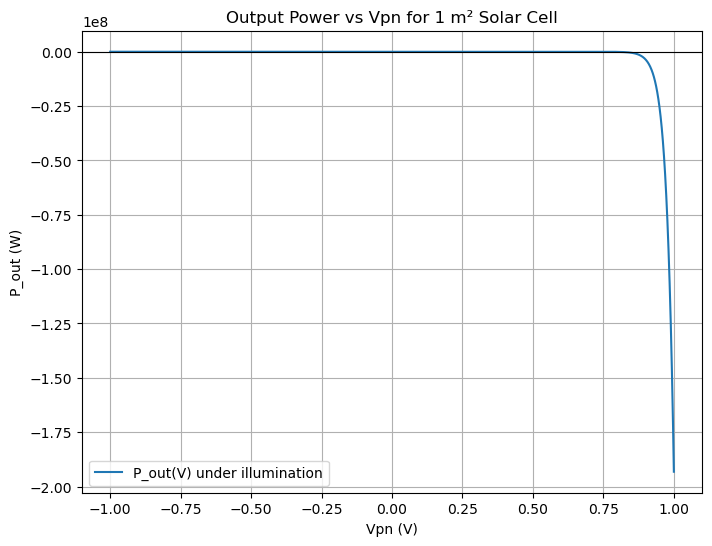

Maximum Power Point:
 V_mpp = 0.5800000000000001 V
 P_mpp = 222.14311918451682 W
 I_mpp = -383.0053779043393 A


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Physical constants
q = 1.602176634e-19
k_B = 1.380649e-23
T = 300.0

# Device parameters
ni = 1.1e10
Nd = 1e20
Na = 1e17
tau_n = 1e-5
tau_p = 1e-5
Dn = 25.0
Dp = 10.0

# Area
area_cm2 = 1e4   # 1 m^2 = 10,000 cm^2

# Diffusion lengths
L_n = np.sqrt(Dn * tau_n)
L_p = np.sqrt(Dp * tau_p)

# Reverse saturation current density J0
J0 = q * (ni**2) * (Dn/(L_n*Na) + Dp/(L_p*Nd))
I0 = J0 * area_cm2  # total saturation current

# Photocurrent (40 mA/cm^2)
I_photo = 0.04 * area_cm2

# Voltage sweep
V = np.linspace(-1, 1, 2001)

# Dark diode current
thermal = q / (k_B * T)
with np.errstate(over="ignore"):
    I_dark = I0 * np.expm1(thermal * V)

# Illuminated current
I_light = I_dark - I_photo

# Output power from solar cell: P_out = -I * V
P_out = -I_light * V

# Plot
plt.figure(figsize=(8,6))
plt.plot(V, P_out, label="P_out(V) under illumination")
plt.axhline(0, color="black", linewidth=0.8)
plt.xlabel("Vpn (V)")
plt.ylabel("P_out (W)")
plt.title("Output Power vs Vpn for 1 m² Solar Cell")
plt.grid(True)
plt.legend()
plt.show()

# Print MPP
idx = np.argmax(P_out)
print("Maximum Power Point:")
print(" V_mpp =", V[idx], "V")
print(" P_mpp =", P_out[idx], "W")
print(" I_mpp =", I_light[idx], "A")


-------------------------------------------------
Knee found at   V_DS = 1.000 V
Threshold V_T ≈ 4.000 V  (using knee method)
-------------------------------------------------


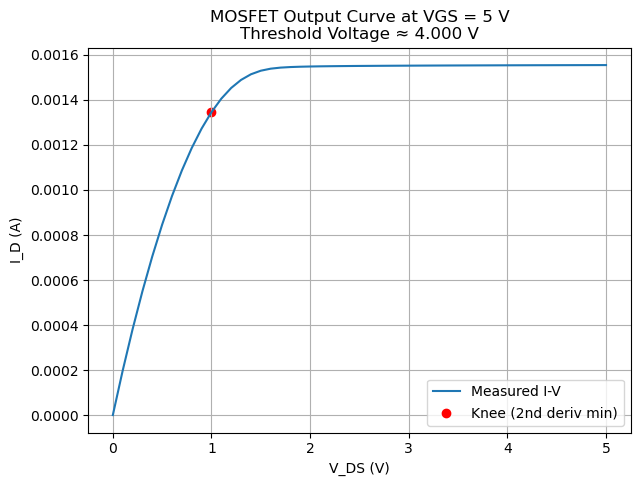

In [ ]:
import csv
import matplotlib.pyplot as plt

# ------------ SETTINGS -------------
filename = "MOSFET Measurement 25 um.csv"
VGS = 5  # Choose: 0, 1, 2, 3, 4, or 5 volts
SMOOTH_WINDOW = 5  # Must be odd
SEARCH_LOW = 1.0   # restrict knee search to avoid noise
SEARCH_HIGH = 6.0
# -----------------------------------

# Build column names
VDS_col = f"GS-2 = {VGS}V DS-1 Voltage (V)"
IDS_col = f"GS-2 = {VGS}V DS-1 Current (A)"

# ------------ LOAD CSV -------------
Vds = []
Ids = []
with open(filename, 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        if row[VDS_col] and row[IDS_col]:
            Vds.append(float(row[VDS_col]))
            Ids.append(float(row[IDS_col]))

# ------------ SIMPLE SMOOTHING -------------
def smooth(data, window):
    half = window // 2
    out = []
    for i in range(len(data)):
        start = max(0, i - half)
        end = min(len(data), i + half + 1)
        out.append(sum(data[start:end]) / (end - start))
    return out

Ids_s = smooth(Ids, SMOOTH_WINDOW)

# ------------ FIRST DERIVATIVE -------------
dIdV = []
for i in range(1, len(Vds)):
    dV = Vds[i] - Vds[i-1]
    dI = Ids_s[i] - Ids_s[i-1]
    dIdV.append(dI / dV if dV != 0 else 0)

# ------------ SECOND DERIVATIVE -------------
d2 = []
for i in range(1, len(dIdV)):
    d1 = dIdV[i] - dIdV[i-1]
    dV = Vds[i+1] - Vds[i]
    d2.append(d1 / dV if dV != 0 else 0)

# Smooth the second derivative too
d2_s = smooth(d2, SMOOTH_WINDOW)

# ------------ SEARCH FOR KNEE -------------
# Restrict to realistic region (avoid noise)
valid_indices = [
    i for i in range(len(d2_s))
    if SEARCH_LOW < Vds[i+1] < SEARCH_HIGH
]

# Pick the most negative second derivative within region
min_index = min(valid_indices, key=lambda i: d2_s[i])

# Convert index back to Vds (accounting for derivative offsets)
knee_index = min_index + 1
V_knee = Vds[knee_index]
I_knee = Ids[knee_index]

# Compute threshold voltage
V_T = VGS - V_knee

print("-------------------------------------------------")
print(f"Knee found at   V_DS = {V_knee:.3f} V")
print(f"Threshold V_T ≈ {V_T:.3f} V  (using knee method)")
print("-------------------------------------------------")

# ------------ PLOT -------------
plt.figure(figsize=(7,5))
plt.plot(Vds, Ids, label="Measured I-V")
plt.scatter([V_knee], [I_knee], color="red", label="Knee (2nd deriv min)")
plt.xlabel("V_DS (V)")
plt.ylabel("I_D (A)")
plt.title(f"MOSFET Output Curve at VGS = {VGS} V\nThreshold Voltage ≈ {V_T:.3f} V")
plt.grid(True)
plt.legend()
plt.show()
